In [21]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import networkx as nx
import metis
import pandas as pd
import random
from scipy.stats import pearsonr
from collections import defaultdict
from datetime import timedelta, datetime
from tqdm import tqdm
from matplotlib import pyplot as plt
from joblib import Parallel, delayed

from rwc import controversy_score
from util import tw_list, get_cut_ratio, add_edges, remove_edges
from leopard import update_partition



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
retweets = pd.read_pickle('data/july.pkl')

In [3]:
retweets.sort_values(by=['created_at'], axis='index', inplace=True)

In [4]:
DEBUG = False
incremental = True
update_interval = timedelta(minutes=5)
T_window = timedelta(minutes=60)
top_node_percent=0.01


In [5]:
# prevent pickling error in multiprocessing
def defaultdict_using_list_func(): 
    return defaultdict(list)

def earlist_date_func(): 
    return datetime(1970, 1, 1)

In [6]:
def run_simulation(update_interval, 
                   T_window, top_node_percent, incremental,
                   top_k=10,
                   top_k_computation_interval=timedelta(days=365),
                   min_rwc_score=0.8,
                   return_log=False,
                   return_graph=False):
    """
    update_interval: graph stat update interval
    T_window: time window 
    top_node_percent: the number of nodes to consider for RWC calculation
    incremental: incremental1 computation or not
    
    top_k: integer
    top_k_computation_interval: interval to update top-k list
    min_rwc_score: minimum RWC score to be considered as controversial
    
    Returns:
    
    tag2log: logging for update on each tag
    running_stat: running statistics
    top_hashtags_by_time: top hashtags at different times
    tag2g: hashtag to graph
    """
    running_stat = {
        'start_time': datetime.now(),
        'update_interval': update_interval, 
        'T_window': T_window,
        'incremental': incremental
    }
    # logging for tags
    tag2log = defaultdict(defaultdict_using_list_func)
    
    # internal data structures
    tag2g = defaultdict(nx.Graph)
    tag2edge_list = defaultdict(tw_list)
    tag2edges_rm = defaultdict(list)
    tag2edges_add = defaultdict(list)
    
    top_hashtags_by_time = []  # TODO: top hashtags at different time points

    last_updated_time = defaultdict(earlist_date_func)
    last_topk_computation_time = earlist_date_func()
    
    for i, rt in tqdm(retweets.head(int(1e5)).iterrows()):
        if i % 5000 == 0:
            # print('#hashtags {}'.format(len(tag2g)))
            # print('now {}'.format(rt['created_at']))
            pass

        h = rt['hashtag']
        g = tag2g[h]  
        edge_list = tag2edge_list[h]

        u, v, now = rt['retweeter'], rt['retweetee'], rt['created_at']

        tag2edges_add[h].append((u, v))
        edge_list.append((u, v), now)
        
        # remove expired edges by triggered hashtag or do it periodically?
        earlist_time = now - T_window
        edges_to_remove = edge_list.remove_before_time(earlist_time)
        if edges_to_remove:
            # print('#edges_to_remove {}'.format(len(edges_to_remove)))
            tag2edges_rm[h] += edges_to_remove

        last_updated_time = g.graph.get('last_updated_time')

        if last_updated_time is None or now - last_updated_time > update_interval:
            # when the graph is processed for the 1st time 
            # and it's very small, it will not be updated
            updated = False

            # update
            edges_to_add = tag2edges_add[h]
            edges_to_rm = tag2edges_rm[h]
            
            # empty it
            tag2edges_add[h] = []
            tag2edges_rm[h] = []

            pr_vects = g.graph.get('pagerank_vectors')
            if not pr_vects or not incremental:  # 1st time                    
                add_edges(g, edges_to_add)
                remove_edges(g, edges_to_rm)
                # g.add_edges_from(edges_to_add)
                # g.remove_edges_from(edges_to_rm)
                
                # remove zero degree nodes
                nodes_to_remove = [n for n in g.nodes_iter() if g.degree(n) == 0]
                if nodes_to_remove:
                    # print('removing {} nodes'.format(len(nodes_to_remove)))
                    g.remove_nodes_from(nodes_to_remove)
                
                if g.number_of_nodes() > 100:  # only calculate RWC when the graph is big enough
                    if DEBUG:
                        # print_log()
                        pass
                    cuts, node_cluster_ids = metis.part_graph(g, 2)
                    node2cluster = {n: c for n, c in zip(g.nodes_iter(), node_cluster_ids)}
                    rwc, aux = controversy_score(g, node2cluster, top_percent=top_node_percent)
                    assert g.number_of_nodes() == len(node_cluster_ids)
                    updated = True
            else:  # incremental
                if DEBUG:
                    print('updating')
                    # print_log()
                node2cluster = g.graph['node2cluster']
                node2cluster = update_partition(g, node2cluster,
                                                edges_to_add=edges_to_add,
                                                edges_to_remove=edges_to_rm,                                                         
                                                verbose=False)
                # print('hashtag {}'.format(h))
                # print('tag2log {}'.format(tag2log[h]))

                # only update if graph is big enough
                if g.number_of_nodes() > 100:
                    pr0 = {n: pr_vects['pr0'].get(n, 0) for n in g.nodes_iter()}
                    pr1 = {n: pr_vects['pr1'].get(n, 0) for n in g.nodes_iter()}
                    rwc, aux = controversy_score(g, node2cluster,
                                                 top_percent=top_node_percent,
                                                 nstart0=pr0,
                                                 nstart1=pr1)
                    updated = True
                else:
                    updated = False
            if updated: 
                # remove zero-degree nodes
                g.graph['node2cluster'] = node2cluster
                g.graph['pagerank_vectors'] = {'pr0': aux['pr0'], 'pr1': aux['pr1']}
                g.graph['rwc'] = rwc
                g.graph['last_updated_time'] = now  # TODO: now should be changed            

                tag2log[h]['rwc'].append(rwc)
                tag2log[h]['graph_size'].append(g.number_of_nodes())
                tag2log[h]['cut_ratio'].append(get_cut_ratio(g, node_cluster_ids))
                tag2log[h]['updated_time'].append(now)


        if (now - last_topk_computation_time) > top_k_computation_interval:                            
            # filter out non-controversial hashtags
            controversial_tags = filter(lambda h: tag2g[h].graph.get('rwc', 0.0) >= min_rwc_score, tag2g)
            
            # top-k hashtag update
            # greedy approach
            node_set = set()
            top_tags = []
            candidate_tags = set(controversial_tags)
            while len(top_tags) < top_k:
                max_set_size = len(node_set)
                best_tag = None
                for h in candidate_tags:
                    new_set_size = len(node_set | set(tag2g[h].nodes()))
                    if max_set_size < new_set_size:
                        max_set_size = new_set_size
                        best_tag = h
                if best_tag is not None:
                    top_tags.append(best_tag)
                    # print('adding {} new nodes from "{}"'.format(len(set(tag2g[best_tag].nodes()) - node_set), best_tag))                
                    node_set |= set(tag2g[best_tag].nodes())
                    candidate_tags.remove(best_tag)
                else:
                    break
            # print('top-k tags: {}'.format(top_tags))
            top_hashtags_by_time.append({
                    'list': [{'tag': t, 
                              'size': tag2g[t].number_of_nodes(),
                              'rwc': tag2g[t].graph['rwc']
                             }
                             for t in top_tags],
                    'time': now
                    })
            last_topk_computation_time = now        

    running_stat['end_time'] = datetime.now()
    to_return = (running_stat, top_hashtags_by_time)
    if return_log:
        to_return += (tag2log, )
    if return_graph:
        to_return += (tag2g, )
    return to_return

In [7]:
# some test
result = run_simulation(T_window=T_window,
                        top_node_percent=top_node_percent,
                        update_interval=update_interval,                        
                        incremental=True,
                        top_k=10,
                        top_k_computation_interval=timedelta(minutes=10),
                        min_rwc_score=0.8                        
                       )
# print((result[1]['end_time'] - result[1]['start_time']).seconds)

100000it [01:28, 1128.75it/s]


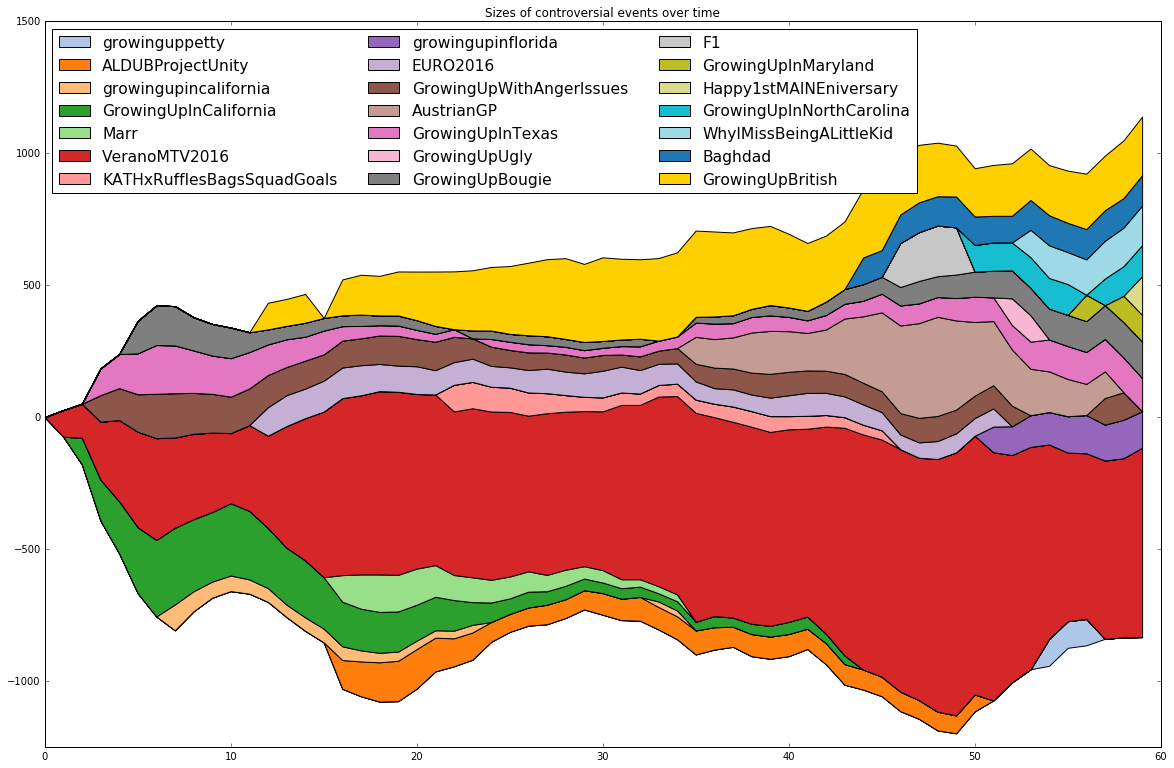

In [39]:
top_k_log = result[1]
tags = list(set([i['tag'] for l in top_k_log for i in l['list']]))

N, M = len(top_k_log), len(tags)

tag2id = {t: i for i, t in enumerate(tags)}
rwc_mat = np.zeros((M, N))
X = np.arange(N)

for i, log in enumerate(top_k_log):
    for item in log['list']:
        rwc_mat[tag2id[item['tag']], i] = item['size']

colors = "#aec7e8 #ff7f0e #ffbb78 #2ca02c #98df8a #d62728 #ff9896 #9467bd #c5b0d5 #8c564b #c49c94 #e377c2 #f7b6d2 #7f7f7f #c7c7c7 #bcbd22 #dbdb8d #17becf #9edae5 #1f77b4 #FFD000".split()
# colors = random.sample(all_colors, len(tags))
fig = plt.figure(figsize=(20, 13))
ax = fig.add_subplot(111)
ax.stackplot(X, rwc_mat, baseline='wiggle', colors=colors)
ax.legend(tags, loc='upper left', ncol=3, fontsize=15.5)
ax.set_ylim([-1250, 1500])
ax.set_title('Sizes of controversial events over time')
fig.savefig('figs/events_stacked_area.pdf')

In [40]:
# update interval vs running time on (incremental, from-scratch)
update_intervals = [timedelta(minutes=i) for i in [4, 8, 16, 32]]
T_window = timedelta(minutes=60)

results = Parallel(n_jobs=8)(delayed(run_simulation)(update_interval=update_interval,
                                                     T_window=T_window,
                                                     top_node_percent=top_node_percent,
                                                     incremental=incremental)
                             for incremental in [True, False]
                             for update_interval in update_intervals)


22045it [00:12, 1984.19it/s]

KeyboardInterrupt: 

In [ ]:
df = pd.DataFrame.from_records([r[0] for r in results])
df['seconds'] = (df['end_time'] - df['start_time']).apply(lambda t: t.seconds)
df['update_interval'] = df['update_interval'].apply(lambda i: i.seconds/60)
df['throughput'] = 1e5 / df['seconds']
df

In [ ]:
leopard = df[df['incremental'] == True]
metis = df[df['incremental'] == False]

plt.plot(leopard['update_interval'], leopard['throughput'], '-o')
plt.plot(metis['update_interval'], metis['throughput'], '-*')
plt.legend(['Incremental', 'From scratch'], loc='upper left')
plt.xlabel('Update interval (minutes)')
plt.ylabel('Throughput (#tweets / second)')
plt.ylim([100, 1400])
plt.title('Throughput vs update interval')
plt.savefig('figs/throughput_comparison.pdf')

In [ ]:
# controversy score on incremental and non-incremental
update_intervals = [timedelta(minutes=i) for i in [5, 10, 15, 20, 25]]
T_window = timedelta(minutes=60)

results = Parallel(n_jobs=8)(delayed(run_simulation)(update_interval=update_interval,
                                                     T_window=T_window,
                                                     top_node_percent=top_node_percent,
                                                     incremental=incremental,
                                                     return_log=True)
                             for incremental in [True, False]
                             for update_interval in update_intervals)


In [ ]:
key1, key2 = 'incremental', 'update_interval'
rows = defaultdict(list)
hashtags = list(results[0][2].keys())
for r in results:
    params, log = r[0], r[2]
    for h in hashtags:
        rows[(params[key1], params[key2])] += log[h]['rwc']
incs, upds = zip(*list(rows.keys()))
rwcs = list(rows.values())
df = pd.DataFrame.from_dict({'incremental': incs, 
                             'update_interval': upds, 
                             'rwcs':rwcs})

In [ ]:
pcr = df.groupby('update_interval').apply(lambda sdf: pearsonr(*sdf['rwcs'])[0])
minutes = pcr.index.map(lambda m: m.seconds/60)
corrs = pcr.values
plt.plot(minutes, corrs, '-o')
plt.xlabel('update interval (minutes)')
plt.ylabel('Correlation coefficient')
plt.title('Pearson correlation coefficient vs update interval')
plt.ylim([0, 1.0])
plt.xlim([min(minutes) - 1, max(minutes) + 1])
plt.savefig('figs/corrs-vs-update-interval.pdf')

In [ ]:
r1 = df[(df['incremental'] == True) & (df['update_interval'] == timedelta(minutes=25))].iloc[0]['rwcs']
r2 = df[(df['incremental'] == False) & (df['update_interval'] == timedelta(minutes=25))].iloc[0]['rwcs']

In [ ]:
plt.scatter(r1, r2)
plt.xlim([0.5, 1.0])
plt.ylim([0.5, 1.0])
plt.xlabel('incremental')
plt.ylabel('from-scratch')
plt.title('RWC score from two approaches')
plt.savefig('figs/ic-fs-rwc-scatter.pdf')

In [ ]:
# the RWC score evoluation of incremental and from-scratch method
h = max(results[0][2].keys(), key=lambda d: len(results[0][2][d]['rwc']))
print(h)
scores = {}
for r in results:
    if r[0]['update_interval'] == timedelta(minutes=5):
        if r[0]['incremental']:
            k = 'incremental'
        else:
            k = 'from scratch'
        scores[k] = r[2][h]['rwc']        

In [ ]:
for k, v in scores.items():
    plt.plot(np.arange(len(v)), v)
plt.legend(scores.keys(), loc='lower right')    

In [ ]:
tag2log, running_stat, top_hashtags_by_time, tag2g = ()
hottest_h = max(tag2g, key=lambda k: tag2g[k].number_of_nodes())

In [ ]:
g = tag2g[hottest_h]
log = tag2log[hottest_h]

In [ ]:
df = pd.DataFrame.from_dict(log)

In [ ]:
df.plot(x='time', y='rwc', ylim=[0.5, 1])

In [ ]:
df.plot(x='time', y='graph_size')

In [ ]:
df.plot(x='time', y='cut_ratio')